In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
digit_mnist_path = 'Digits-MNIST/train.csv'
fashion_mnist_path = 'Fashion-MNIST/fashion-mnist_train.csv'

pdf_digits = pd.read_csv(digit_mnist_path)
pdf_fashion = pd.read_csv(fashion_mnist_path)

pdf_digits['label'] = np.where(pdf_digits['label']==0,1,-1)
pdf_fashion['label'] = np.where(pdf_fashion['label']==0,1,-1)

test_size = 0.2
SEED = 22
np.random.seed(SEED)

def sample_and_shuffle(df):
    df_p = df[df['label']==1]
    df_n = df[df['label']==-1]
    df_n_sample = df_n.sample(int(1.5*len(df_p.index)))

    df_new = df_p.append(df_n_sample)
    df_new_shuffled = shuffle(df_new)

    return df_new_shuffled

pdf_digits = sample_and_shuffle(pdf_digits)
pdf_fashion = sample_and_shuffle(pdf_fashion)

# pdf_digits = shuffle(pdf_digits)
# pdf_fashion = shuffle(pdf_fashion)

x_dig, y_dig =  pdf_digits[pdf_digits.columns[1:]].to_numpy()/255, pdf_digits['label'].to_numpy(),
x_fash, y_fash = pdf_fashion[pdf_fashion.columns[1:]].to_numpy()/255, pdf_fashion['label'].to_numpy()

x_dig_train, x_dig_test, y_dig_train, y_dig_test = train_test_split(x_dig, y_dig, test_size = test_size)
x_fash_train, x_fash_test, y_fash_train, y_fash_test = train_test_split(x_fash, y_fash, test_size = test_size)

In [198]:
class Model:
    params = np.array([])
    reg = False
    proxy = False

    alpha = 0
    beta = 0
    gamma = 0

    def __init__(self, reg = False, proxy = False, alpha = 1, beta = 2, gamma = 0.1):
        self.reg = reg
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        if proxy:
            self.reg = False
            self.proxy = True

    def initialize_params(self, data):
        self.params = np.random.normal(0,1,len(data[0])+1)

    def learning_rates(self, k):
        return 1/k
    
    def proximal_operator(self):
        return np.where(
            np.abs(self.params) >self.alpha*self.beta, 
            self.params, 
            np.where(
                np.abs(self.params)<= self.alpha,
                0,
                np.sign(self.params)*(np.abs(self.params)-self.alpha)/(1-1/self.beta)
            )
        )

    def subgradient(self, data, target, batch_size):
        sample_idxs = np.random.randint(np.shape(data)[0], size=batch_size)
        x_batch, y_batch  = data[sample_idxs,:], target[sample_idxs]

        loss_grad = np.zeros(1+len(data[0]))

        # hinge_loss = lambda x: 1-x[-1]*(np.dot(self.params[1:], x[:-1])-self.params[0])
        # hinge_subgrad = lambda x: np.append(np.where(hinge_loss(x)>0, x[-1], 0), np.where(hinge_loss(x)>0, -x[-1]*x[:-1], 0))
        # data_join = np.concatenate((x_batch, y_batch.reshape((-1,1))), 1)
        # loss_grad = np.apply_along_axis(hinge_subgrad, 1, data_join)/batch_size

        for i in range(np.shape(x_batch)[0]):
            x = x_batch[i]
            y = y_batch[i]
            hinge_loss = 1-y*(np.dot(self.params[1:], x)-self.params[0])
            loss_grad += np.append(np.where(hinge_loss>0, y, 0), np.where(hinge_loss>0, -y*x, 0))
        loss_grad = loss_grad/batch_size

        if self.reg:
            return loss_grad+self.gamma*self.regularization_subgradient()
        else:
            return loss_grad

    def regularization_subgradient(self):
        return np.where(
            np.abs(self.params) <= self.alpha*self.beta, 
            self.alpha*np.sign(self.params) - self.params/self.beta, 
            0
        )

    def regularization_loss(self):
        return np.where(
            np.abs(self.params) <= self.alpha*self.beta,
            self.alpha*np.abs(self.params) - np.square(self.params)/(2*self.beta),
            self.alpha*self.beta**2/2
        ).sum()

    def predict(self, data):
        f = lambda x: np.dot(self.params[1:], x)- self.params[0]
        predictions = np.apply_along_axis(f, 1, data)
        predictions = np.where(predictions < 0, -1, 1)
        return predictions

    def loss(self, data, target):
        data_join = np.concatenate((data, target.reshape((-1,1))), 1)
        hinge_loss = lambda x: np.maximum(0, 1-x[-1]*(np.dot(self.params[1:], x[:-1])-self.params[0]))
        loss = np.apply_along_axis(hinge_loss, 1, data_join).mean()
        if self.reg or self.proxy:
            # return loss + self.gamma*self.regularization_loss()
            return loss
        else:
            return loss

    def accuracy(self, data, target):
        predictions = self.predict(data)
        acc = (predictions==target).mean()
        return acc

    def sparsity(self):
        return (np.isclose(self.params,0, atol=1e-6)).mean()

    def train(self, data, target, n_iter = 10**5, batch_size = 1, verbose = True):
        self.initialize_params(data)

        for i in range(1, n_iter+1):
            self.params  = self.params - self.learning_rates(i)*self.subgradient(data, target, batch_size)
            if self.proxy:
                self.params = self.proximal_operator()

            if verbose and i%10000 == 0:
                l= self.loss(data, target)
                acc = self.accuracy(data, target)
                spars = self.sparsity()
                print(f'Iterace {i}: Ztráta: {l}, přesnost: {acc}, řídkost: {spars}')

    def save_model(self, file_name):
        with open(f'{file_name}.pkl', 'wb') as f:
            pickle.dump(self, f)

    def training_data(self, data, target, n_iter = 10**5, batch_size = 10, interval = 10):
        self.initialize_params(data)

        loss_data, accuracy_data, sparsity_data = np.array([]), np.array([]), np.array([])
        idxs =  np.array([])
        for i in range(1, n_iter+1):
            self.params  = self.params - self.learning_rates(i)*self.subgradient(data, target, batch_size)
            if self.proxy:
                self.params = self.proximal_operator()

            if (i-1)%interval == 0 or (i-1)<=10:
                l= self.loss(data, target)
                acc = self.accuracy(data, target)
                spars = self.sparsity()

                idxs = np.append(idxs, i)
                loss_data = np.append(loss_data, l)
                accuracy_data = np.append(accuracy_data, acc)
                sparsity_data = np.append(sparsity_data, spars)
                # print(f'Iterace {i}: Ztráta: {l}, přesnost: {acc}, řídkost: {spars}')
        return loss_data, accuracy_data, sparsity_data, idxs



def perform_experiments(model, data_train, target_train, data_test, target_test, n_iter = 10**5, batch_size = 1, n_experiments = 10):
    losses_train, accuracies_train = np.array([]), np.array([])
    losses_test, accuracies_test = np.array([]), np.array([])
    sparsities = np.array([])

    for i in range(1, n_experiments+1):
        np.random.seed(i)
        model.train(data_train, target_train, n_iter, batch_size, False)

        losses_train = np.append(losses_train, model.loss(data_train, target_train)) 
        accuracies_train = np.append(accuracies_train, model.accuracy(data_train, target_train))

        losses_test = np.append(losses_test, model.loss(data_test, target_test)) 
        accuracies_test = np.append(accuracies_test, model.accuracy(data_test, target_test))

        sparsities = np.append(sparsities, model.sparsity())

        print(f'Experiment číslo {i} ukončen.')
    np.random.seed(SEED)
    
    return pd.DataFrame(
        {
            "Sparsity": sparsities,
            "Train loss": losses_train,
            "Test loss": losses_test,
            "Train accuracy": accuracies_train,
            "Test accuracy": accuracies_test
        },
        index = [f"Experiment {i}" for i in range(1, n_experiments+1)]
    )

def plot_training_data(models, data, target, n_iter = 10**5, batch_size = 10, interval = 10):
    losses, accuracies, sparsities = [], [], []
    idxs = []
    for model in models:
        x, y, z, w = model.training_data(data, target, n_iter, batch_size, interval)
        losses.append(x), accuracies.append(y), sparsities.append(z)
        idxs.append(w)
    
    plot_loss(losses, idxs[0])
    plot_accuracy(accuracies, idxs[1])
    plot_sparsity(sparsities, idxs[2])
    
def plot_loss(data, idxs):
    fig, ax = plt.subplots()
    labels = ['SSGD', 'SSGD s regularizací', 'PSSGD']
    for y, l in zip(data, labels):
        ax.plot(idxs, y, label = l)
    ax.legend(fontsize=12)
    ax.set_xscale('log')
    ax.xaxis.set_tick_params(width=2.5)
    ax.yaxis.set_tick_params(width=2.5)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Počet iterací", fontsize=15)
    plt.ylabel('Ztrátová funkce', fontsize=15)
    plt.tight_layout()
    plt.savefig('loss_plot_fash.pdf', format='pdf')
    plt.show()

def plot_accuracy(data, idxs):
    fig, ax = plt.subplots()
    labels = ['SSGD', 'SSGD s regularizací', 'PSSGD']
    for y, l in zip(data, labels):
        ax.plot(idxs, y, label = l)
    ax.legend(fontsize=12)
    ax.set_xscale('log')
    ax.xaxis.set_tick_params(width=2.5)
    ax.yaxis.set_tick_params(width=2.5)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Počet iterací", fontsize=15)
    plt.ylabel('Přesnost', fontsize=15)
    plt.tight_layout()
    plt.savefig('acc_plot_fash.pdf', format='pdf')
    plt.show()

def plot_sparsity(data, idxs):
    fig, ax = plt.subplots()
    labels = ['SSGD', 'SSGD s regularizací', 'PSSGD']
    for y, l in zip(data, labels):
        ax.plot(idxs, y, label = l)
    ax.legend(fontsize=12)
    ax.set_xscale('log')
    ax.xaxis.set_tick_params(width=2.5)
    ax.yaxis.set_tick_params(width=2.5)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Počet iterací", fontsize=15)
    plt.ylabel('Řídkost', fontsize=15)
    plt.tight_layout()
    plt.savefig('spars_plot_fash.pdf', format='pdf')
    plt.show()

In [55]:
digit_loss, digit_acc, digit_spars = Model().training_data(x_dig, y_dig)
digit_reg_loss, digit_reg_acc, digit_reg_spars = Model(reg= True).training_data(x_dig, y_dig)
digit_proxy_loss, digit_proxy_acc, digit_proxy_spars = Model(proxy= True, alpha=0.5, beta=1.5).training_data(x_dig, y_dig)

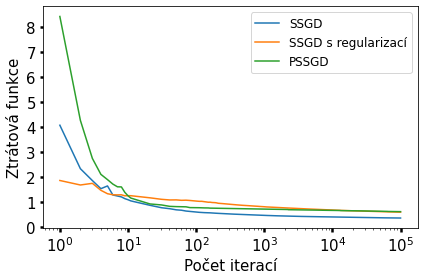

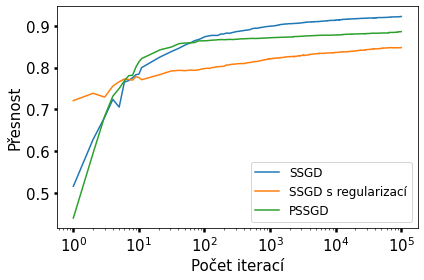

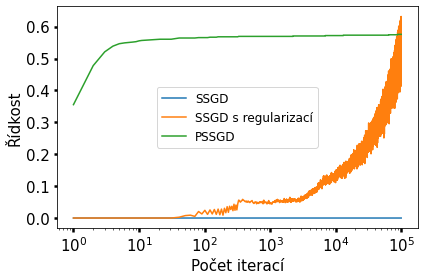

In [197]:
plot_training_data(
    models= [Model(), Model(reg= True),  Model(proxy= True, alpha=0.5, beta=1.5)],
    data= x_dig,
    target= y_dig,
    n_iter= 10**5,
    batch_size= 10,
    interval= 10
)

In [ ]:
plot_training_data(
    models= [Model(), Model(reg= True),  Model(proxy= True, alpha=0.5, beta=1.5)],
    data= x_fash,
    target= y_fash,
    n_iter= 10**5,
    batch_size= 10,
    interval= 10
)

In [ ]:
plot_training_data(
    models= [Model(), Model(reg= True),  Model(proxy= True, alpha=0.5, beta=1.5)],
    data= x_dig,
    target= y_dig,
    n_iter= 10**5,
    batch_size= 10,
    interval= 10
)

In [129]:
digit_exp = perform_experiments(
    model= Model(),
    data_train= x_dig_train,
    target_train= y_dig_train,
    data_test= x_dig_test,
    target_test= y_dig_test,
    n_iter= 10**5,
    batch_size= 10,
    n_experiments= 10
)
digit_exp.to_csv('digit_exp.csv')
print(digit_exp.mean())
print(digit_exp.std())

Experiment číslo 1 ukončen.
Experiment číslo 2 ukončen.
Experiment číslo 3 ukončen.
Experiment číslo 4 ukončen.
Experiment číslo 5 ukončen.
Experiment číslo 6 ukončen.
Experiment číslo 7 ukončen.
Experiment číslo 8 ukončen.
Experiment číslo 9 ukončen.
Experiment číslo 10 ukončen.


In [130]:
digit_reg_exp = perform_experiments(
    model= Model(reg= True),
    data_train= x_dig_train,
    target_train= y_dig_train,
    data_test= x_dig_test,
    target_test= y_dig_test,
    n_iter= 10**5,
    batch_size= 10,
    n_experiments= 10
)
digit_reg_exp.to_csv('digit_reg_exp.csv')
print(digit_reg_exp.mean())
print(digit_reg_exp.std())

Experiment číslo 1 ukončen.
Experiment číslo 2 ukončen.
Experiment číslo 3 ukončen.
Experiment číslo 4 ukončen.
Experiment číslo 5 ukončen.
Experiment číslo 6 ukončen.
Experiment číslo 7 ukončen.
Experiment číslo 8 ukončen.
Experiment číslo 9 ukončen.
Experiment číslo 10 ukončen.


In [131]:
fashion_exp = perform_experiments(
    model= Model(),
    data_train= x_fash_train,
    target_train= y_fash_train,
    data_test= x_fash_test,
    target_test= y_fash_test,
    n_iter= 10**5,
    batch_size= 10,
    n_experiments= 10
)
fashion_exp.to_csv('fashion_exp.csv')
print(fashion_exp.mean())
print(fashion_exp.std())


Experiment číslo 1 ukončen.
Experiment číslo 2 ukončen.
Experiment číslo 3 ukončen.
Experiment číslo 4 ukončen.
Experiment číslo 5 ukončen.
Experiment číslo 6 ukončen.
Experiment číslo 7 ukončen.
Experiment číslo 8 ukončen.
Experiment číslo 9 ukončen.
Experiment číslo 10 ukončen.


In [195]:
fashion_reg_exp = perform_experiments(
    model= Model(reg= True),
    data_train= x_fash_train,
    target_train= y_fash_train,
    data_test= x_fash_test,
    target_test= y_fash_test,
    n_iter= 10**5,
    batch_size= 10,
    n_experiments= 10
)
fashion_reg_exp.to_csv('fashion_reg_exp.csv')
print(fashion_reg_exp.mean())
print(fashion_reg_exp.std())


KeyboardInterrupt: 

In [133]:
digit_proxy_exp = perform_experiments(
    model= Model(proxy= True, alpha=0.5, beta=1.5),
    data_train= x_dig_train,
    target_train= y_dig_train,
    data_test= x_dig_test,
    target_test= y_dig_test,
    n_iter= 10**5,
    batch_size= 10,
    n_experiments= 10
)
digit_proxy_exp.to_csv('digit_proxy.csv')
print(digit_proxy_exp.mean())
print(digit_proxy_exp.std())

Experiment číslo 1 ukončen.
Experiment číslo 2 ukončen.
Experiment číslo 3 ukončen.
Experiment číslo 4 ukončen.
Experiment číslo 5 ukončen.
Experiment číslo 6 ukončen.
Experiment číslo 7 ukončen.
Experiment číslo 8 ukončen.
Experiment číslo 9 ukončen.
Experiment číslo 10 ukončen.


In [134]:
fashion_proxy_exp = perform_experiments(
    model= Model(proxy= True, alpha=0.5, beta=1.5),
    data_train= x_fash_train,
    target_train= y_fash_train,
    data_test= x_fash_test,
    target_test= y_fash_test,
    n_iter= 10**5,
    batch_size= 10,
    n_experiments= 10
)
fashion_proxy_exp.to_csv('fashion_proxy.csv')
print(fashion_proxy_exp.mean())
print(fashion_proxy_exp.std())

Experiment číslo 1 ukončen.
Experiment číslo 2 ukončen.
Experiment číslo 3 ukončen.
Experiment číslo 4 ukončen.
Experiment číslo 5 ukončen.
Experiment číslo 6 ukončen.
Experiment číslo 7 ukončen.
Experiment číslo 8 ukončen.
Experiment číslo 9 ukončen.
Experiment číslo 10 ukončen.


In [ ]:
pd.options.display.float_format = '{:,.2f}%'.format

dig_res = pd.DataFrame(
    data = {
        "Přesnost": [dig_ssgd_acc, reg_dig_ssgd_acc, dig_pssgd_acc],
        "Řídkost": [dig_ssgd_spars, reg_dig_ssgd_spars, dig_pssgd_spars]
    },
    index= ["SSGD", "SSGD+reg", "PSSGD+reg"]
)

dig_res = 100*dig_res

dig_res['Rozdíl přesností'] = dig_res['Přesnost'].apply(lambda x: x-dig_res['Přesnost'].values[0])
dig_res['Rozdíl řídkostí'] = dig_res['Řídkost'].apply(lambda x: x-dig_res['Řídkost'].values[0])

dig_res.to_csv("Results_digits.csv")
dig_res

In [ ]:
fash_res = pd.DataFrame(
    data = {
        "Přesnost": [fash_ssgd_acc, reg_fash_ssgd_acc, fash_pssgd_acc],
        "Řídkost": [fash_ssgd_spars, reg_fash_ssgd_spars, fash_pssgd_spars]
    },
    index= ["SSGD", "SSGD+reg", "PSSGD+reg"]
)

fash_res = 100*fash_res

fash_res['Rozdíl přesností'] = fash_res['Přesnost'].apply(lambda x: x-fash_res['Přesnost'].values[0])
fash_res['Rozdíl řídkostí'] = fash_res['Řídkost'].apply(lambda x: x-fash_res['Řídkost'].values[0])

fash_res.to_csv("Results_fashion.csv")
fash_res

In [ ]:
alpha0, beta0 = 1, 4

lamb = 0.1

def accuracy(data, target, params):
    preds = np.apply_along_axis(lambda x: np.dot(params[1:], x)- params[0], 1, data)
    preds = np.where(preds < 0, -1, 1)
    acc = (preds==target).mean()
    return acc

def sparsity(params):
    return (~np.isclose(params,0, rtol=1e-6)).mean()

def optimize_SSGD(data, target, samples, max_iter, reg = True, verbose = True, plot = False):
    def hinge_loss(params):
        s = 0
        for i in range(len(data)):
            s += np.maximum(0, 1-target[i]*(np.dot(params[1:], data[i])-params[0]))
        return s/len(data)

    def l1(params):
        return np.abs(params).sum()

    def loss(params):
        if reg: 
            return hinge_loss(params) + lamb*l1(params)
        else:
            return hinge_loss(params)

    def subgradient(params, i):
        x_batch, y_batch  = data[samples[i],:], target[samples[i]]
        g1 = np.zeros(1+len(data[0]))
        for i in range(np.shape(x_batch)[0]):
            x = x_batch[i]
            y = y_batch[i]
            h = 1-y*(np.dot(params[1:],x)-params[0])
            g1 += np.append(np.where(h>0, y, 0), np.where(h >0, -y*x,0))
        g1 = g1/np.shape(x_batch)[0]
        if reg:
            g2 = np.sign(params)
            # g2 = params
            g2 = np.where(np.abs(params)< alpha0*beta0, alpha0*np.sign(params)- params/beta0, alpha0*beta0*beta0/2)
            return g1+lamb*g2
        else:
            return g1

    def rates(k):
        return 1/(k+1)

    def sparsity(params):
        return (np.isclose(params,0, rtol=1e-6)).mean()

    plot_acc, plot_spars = np.array([]), np.array([])
    params = np.random.normal(0,1,len(data[0])+1)
    for i in range(max_iter):
        params  = params - rates(i)*subgradient(params, i)
        if verbose and (i+1)%10000 == 0:
            l = loss(params)
            acc = accuracy(data, target, params)
            spars = sparsity(params)
            print(f'Iterace {i+1}: Ztráta: {l}, přesnost: {acc}, řídkost: {spars}')

        if plot and i%10==0 and i<=10000:
            plot_acc = np.append(plot_acc, accuracy(data, target, params))
            plot_spars = np.append(plot_spars, sparsity(params))

    return params, loss(params), accuracy(data, target, params), sparsity(params) , (plot_acc, plot_spars)

def perform_experiments_SSGD(data_train, target_train, data_test, target_test, n_iter, n_experiments, reg=True):
    losss_train, accs_train, sparss_train = np.array([]), np.array([]), np.array([])
    test_accs = np.array([])
    for i in range(n_experiments):
        np.random.seed(i)
        samples = np.random.randint(np.shape(data_train)[0], size=n_iter).reshape((n_iter,mini_batch))
        params, loss, acc, spars, _ = optimize_SSGD(data_train, target_train, samples, n_iter, reg, False, False)
        test_acc = accuracy(data_test, target_test, params)

        test_accs = np.append(test_accs, test_acc)
        losss_train = np.append(losss_train, loss) 
        accs_train = np.append(accs_train, acc)
        sparss_train = np.append(sparss_train, spars)

        # print(f'Kolo {i+1}: done.')
    print('Done')
    return losss_train.mean(), accs_train.mean(), sparss_train.mean(), test_accs.mean()

In [ ]:
alpha, beta = 0.5, 2

def accuracy(data, target, params):
    preds = np.apply_along_axis(lambda x: np.dot(params[1:], x)- params[0], 1, data)
    preds = np.where(preds < 0, -1, 1)
    acc = (preds==target).mean()
    return acc

def sparsity(params):
    return (np.isclose(params,0, rtol=1e-6)).mean()

def optimize_PSSGD(data, target, samples, max_iter, verbose = True, plot = True):
    def hinge_loss(params):
        s = 0
        for i in range(len(data)):
            s += np.maximum(0, 1-target[i]*(np.dot(params[1:], data[i])-params[0]))
        return s/len(data)

    def mcp(params):
        return np.where(np.abs(params)<= alpha*beta, (alpha*np.abs(params)- params**2/(2*beta)),  beta*alpha**2/2).sum()

    def loss(params):
        return hinge_loss(params) + mcp(params)

    def subgradient(params, i):
        x_batch, y_batch  = data[samples[i],:], target[samples[i]]
        g1 = np.zeros(1+len(data[0]))
        for i in range(np.shape(x_batch)[0]):
            x = x_batch[i]
            y = y_batch[i]
            h = 1-y*(np.dot(params[1:],x)-params[0])
            g1 += np.append(np.where(h>0, y, 0), np.where(h >0, -y*x,0))
        g1 = g1/np.shape(x_batch)[0]
        g1 = np.append(np.where(h>0, y, 0), np.where(h >0, -y*x,0))
        return g1

    def proxy_operator(params):
        def proxy(w):
            if np.abs(w)>alpha*beta:
                return w
            elif  np.abs(w)<= alpha:
                return 0
            else:
                return np.sign(w)*(abs(w)-alpha)/(1-1/beta)
        out = np.where(np.abs(params) >alpha*beta, params, np.where(np.abs(params)<= alpha,0,np.sign(params)*(np.abs(params)-alpha)/(1-1/beta)))
        # out = np.array(list(map(proxy,params)))
        # out = np.vectorize(proxy)(params)
        # out = np.fromiter((proxy(xi) for xi in params), params.dtype)
        return out
        
    def rates(k):
        return 1/(k+1)

    plot_acc, plot_spars = np.array([]), np.array([])
    params = np.random.normal(0,1,len(data[0])+1)
    for i in range(max_iter):
        params = params - rates(i)*subgradient(params, i)
        params = proxy_operator(params)
        if verbose and  (i+1)%10000 == 0:
            l1 = loss(params)
            acc = accuracy(data, target, params)
            spars = sparsity(params)
            print(f'Iterace {i+1}: Ztráta: {l1}, přesnost: {acc}, řídkost: {spars}')

        if plot and i%10==0 and i<=1000:
            plot_acc = np.append(plot_acc, accuracy(data, target, params))
            plot_spars = np.append(plot_spars, sparsity(params))

    return params, loss(params), accuracy(data, target, params), sparsity(params) , (plot_acc, plot_spars)

def perform_experiments_PSSGD(data_train, target_train, data_test, target_test, n_iter, n_experiments):
    losss_train, accs_train, sparss_train = np.array([]), np.array([]), np.array([])
    test_accs = np.array([])
    for i in range(n_experiments):
        np.random.seed(i)
        samples = np.random.randint(np.shape(data_train)[0], size=n_iter*mini_batch).reshape((n_iter,mini_batch))
        params, loss, acc, spars, _ = optimize_PSSGD(data_train, target_train, samples, n_iter, False, False)
        test_acc = accuracy(data_test, target_test, params)

        test_accs = np.append(test_accs, test_acc)
        losss_train = np.append(losss_train, loss) 
        accs_train = np.append(accs_train, acc)
        sparss_train = np.append(sparss_train, spars)

        # print(f'Kolo {i+1}: done.')
    print('Done')
    return losss_train.mean(), accs_train.mean(), sparss_train.mean(), test_accs.mean()